# Tema 4: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 tipuri de cifre din setul MNIST.

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara. 
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. in definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Folositi unul din optimizatorii: Adam, RMSprop, Adagrad.

Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se pana in 10 aprilie ora 23, in cadrul temei 4 de pe platforma. Modul de predare si de rpezentare aeste la fel ca pentru temele precedente.

## Importarea pachetelor necesare 

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.2+cpu  Device: cpu


Pachetul torch-summary este util pentru obtinerea sumarului unui model instruibil: numar de ponderi instruibile, dimensiune etc. 

In [45]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [46]:
from torchinfo import summary

## Pregatirea setului de date: clasa de tip Dataset

In [47]:
# importam clasa de baza Dataset:
from torch.utils.data import Dataset

In [48]:
# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd
import os
from typing import Tuple

In [49]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Initializeaza setul de date, folosind o cale catre fisier csv si numarul de clase
        :param path_csv: cale catre fisier CSV care contine date de train sau test
        :param positive_class: indice de clasa pozitiva, numar 0...9
        :param negative_class: indice de clasa negativa, numar 0...9 diferit de :param positive_class:
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte 
        super().__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        self.path_csv = path_csv
        
        _all_digits = pd.read_csv(path_csv, header=None).values
        # valorile de intrare in x, etichetele in y 
        _y = _all_digits[:, 0]
        _x = _all_digits[:, 1:]
        # valorile 0..255 din setul de intrare _x sunt scalate la 0..1
        _x = _x / 255

        self.x = _x
        self.y = _y

        # convertim din numpy array in torch tensors:
        self.x = torch.Tensor(self.x)
        self.y = torch.Tensor(self.y)
        
    def __len__(self):
        """
        Returneaza lungimea setului de date curent
        :return: lungimea setului de date
        """
        return len(self.y)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returneaza perechea (intrare, eticheta_asociata) de pe pozitia :param index:
        :param index: pozitia de pe care se returneaza vectorul si clasa lui
        :return: pereche: vector de intarre de 784 de elemente, eticheta 
        """
        return self.x[index, :], self.y[index]

In [50]:

train_ds = MNISTDataset('./data/mnist_train.csv')
test_ds = MNISTDataset('./data/mnist_test.csv')

assert len(train_ds) == 60000
assert len(test_ds) == 10000

## Incarcarea datelor folosind un DataLoader


In [51]:
from torch.utils.data import DataLoader

In [52]:
batch_size = 32 # in functie de memoria disponibila pe GPU
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# pentru primul minibatch tiparim 'shape'
# datele de intrare ar tb sa fie un tensor de forma (batch_size x 784)
# etichetele ar trebui sa fie un tensor de forma batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    # print(data, label)
    break
    
# restul de minibatchuri arata la fel, eventual exceptand ultimul minibatch

torch.Size([32, 784]) torch.Size([32])


## Definirea modelului

In Pytorch un model este o clasa derivata din `torch.nn.Module`. Esentiale sunt implementarea de:
* metoda de initializare, `__init__`
* metoda `forward` care preia un minibatch de intrare si produce o estimare

Metoda de initializare construieste ponderile. 

In [53]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784):
        """
        Initializarea unui obiect de tip LogisticRegression
        :param input_size: dimensiunea unui vector de intrare. De ex, pt MINST este 784
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super().__init__()
        self.input_size = input_size
        # matrice = operator liniar
        self.fully_connected = nn.Linear(input_size, 10, bias=True)

    def forward(self, x):
        # x este un minibatch de exemplu de forma 32x784 (ultimul minibatch poate avea mai putin de 32 de tensori)

        # se propaga dinspre stratul de intrare spre primul strat ascuns
        # aplicarea unei functii liniare este echivalenta cu inmulttirea unei matrice cu intrarea curenta
        logits = self.fully_connected(x)
        return logits

Instantiem modelul:

In [54]:
model = MultinomialLogisticRegression(input_size=784)

Tiparim modelul:

In [55]:
print(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


Mai multe detalii se afla cu functia `summary()`:

In [56]:
summary(model)

Layer (type:depth-idx)                   Param #
MultinomialLogisticRegression            --
├─Linear: 1-1                            7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

Trecem modelul pe device. Daca device=cpu, atunci linia de mai jos nu are niciun efect. Daca device=cuda, atunci modelul este trecut in GPU si rularea va fi mai rapida:

In [57]:
print(f'device={device}')
model.to(device)

device=cpu


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

## Scurt demo: ce prezice modelul pentru primul minibatch din setul de antrenare?

In [58]:
for x, y in train_loader:
    # datele si modelul trebuie sa fie pe acelasi device, altfel calculele nu se pot efectua
    x, y = x.to(device), y.to(device)
    
    # produce predictia, tensor plin cu probabilitati
    logits = model(x)

   # Clasa prezisă este cea cu probabilitatea cea mai mare
    predicted_classes = torch.argmax(logits, dim=1)
    # clase e un vector de booleni; True = 1, False = 0
    print('Cate clase au fost prezise corect: ', (predicted_classes == y).sum())
    
    # ne oprim dupa primul minibatch aici, e doar pentru a vedea cum arata predictiile facute de model
    break 

Cate clase au fost prezise corect:  tensor(2)


## Antrenarea modelului

Vom avea mai multe epoci de antrenare. In fiecare epoca:
* se parcurg toate minibatchurile de date din train_loader
* se calculeaza functie de eroare pe minibatch, se calculeaza gradientii, se aplica gradientii pentru modificarea ponderilor
* la finalul fiecarei epoci se ruleaza modelul pe setul de testare, pentru a vedea acuratetea obtinuta

In [59]:
# dezactivam urmarirea automata a tensorilor pentru care se pot calcula gradienti:
# gradientii sunt folositidoar la antrenare, nu si la testare
@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Testeaza modelul pe datele furnizate de :param loader:
    :param model: modelul de regresie logistica multinomiala
    :param loader: un dataloader care furnizeaza datele din setul de testare
    :param device: pe ce device se afla modelul (cpu, gpu, tpu etc)
    :return: acuratetea de predictie
    """
    # initializare valori pt statistica
    correctly_classified = 0
    total_items = 0
    # cand se face testarea, modelul nu mai invata. El e trecut explicit in mod de testare
    model.eval()
    for x, y in loader:
        # trecem datele din setul de testare pe acelasi device ca si modelul
        x, y = x.to(device), y.to(device)
        
        # modelul prezice probabilitatile conditionate pentru minibatchul curent
        logits = model(x)
        
        # predictia e clasa pozitiva daca probabilitatea e >=0.5, altfel clasa negativa
        predicted_class = torch.argmax(logits, dim=1)
        
        correctly_classified += torch.sum(predicted_class == y)
        total_items += len(x)
    accuracy = correctly_classified / total_items
    return accuracy.cpu().detach().item()

Acuratetea modelulului neantrenat pe setul de testare este:

In [60]:
acc = test(model, test_loader, device)
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

Acuratetea modelului neantrenat: 10.050000250339508%


Instantiem optimizator

In [61]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, weight_decay=1e-3)

Functia de eroare este binary cross entropy:

In [62]:
# definim functia de eroare,cross entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

In [63]:
# numarul de epoci
epochs = 30

In [64]:
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
for epoch in range(epochs):
    # modelul trebuie trecut in modul train inainte de a se face instruirea lui
    # trecerea lui pe modul eval apare la apelul metodei de test()
    model.train()
    epoch_loss_train = 0
    total_items_train = 0
    for x_train, y_train in train_loader:
        # trecem datele din setul de antrenare pe acelasi device ca si modelul
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        # stergem gradientii calculati anterior, altfel se face acumulare e gradienti - nu e de interes pt acest model
        model.zero_grad()
        
        # modelul prezice probabilitatile conditionate pentru minibatchul curent
        logits_train = model(x_train)
        
        # se calculeaza functia de eroare pe minibatchul curent
        loss_train = loss_fn(logits_train, y_train.long())
        # loss-ul calculat este media valorii de eroare peste minibatchul curent; 
        # inmultim media cu numarul de valori din minibatch pentru a determina valoarea cumulata 
        # a erorii pe minibatch
        epoch_loss_train += loss_train.item() * len(x_train)
        # actualizam numarul total de valori peset care s-a facut invatarea
        total_items_train += len(x_train)
        
        # cerem calcul de gradienti
        loss_train.backward()
        
        # optimizatorul aplica gradientii pe ponderi = invatare
        optimizer.step()
    
    epoch_loss_train /= total_items_train
    losses_train.append(epoch_loss_train)

    acc_train = test(model, train_loader, device)
    accuracies_train.append(acc_train)

    model.eval()
    epoch_loss_test = 0
    total_items_test = 0
    
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        logits_test = model(x_test)
        loss_test = loss_fn(logits_test, y_test.long())
        epoch_loss_test += loss_test.item() * len(x_test)
        total_items_test += len(x_test)

    epoch_loss_test /= total_items_test
    losses_test.append(epoch_loss_test)

    acc_test = test(model, test_loader, device)
    accuracies_test.append(acc_test)
    
    
    print(f'Epoca: {epoch+1}/{epochs}: loss = {epoch_loss_train:.7f}')
    
    print(f'Epoca: {epoch + 1}/{epochs}: acuratete pe setul de testare = {acc_test * 100:.4f}%\n')

Epoca: 1/30: loss = 0.3569424
Epoca: 1/30: acuratete pe setul de testare = 92.0100%

Epoca: 2/30: loss = 0.3063391
Epoca: 2/30: acuratete pe setul de testare = 91.9200%

Epoca: 3/30: loss = 0.3007141
Epoca: 3/30: acuratete pe setul de testare = 91.9000%

Epoca: 4/30: loss = 0.2979696
Epoca: 4/30: acuratete pe setul de testare = 92.0600%

Epoca: 5/30: loss = 0.2962094
Epoca: 5/30: acuratete pe setul de testare = 91.8200%

Epoca: 6/30: loss = 0.2950108
Epoca: 6/30: acuratete pe setul de testare = 92.1600%

Epoca: 7/30: loss = 0.2944385
Epoca: 7/30: acuratete pe setul de testare = 91.8900%

Epoca: 8/30: loss = 0.2930434
Epoca: 8/30: acuratete pe setul de testare = 91.9300%

Epoca: 9/30: loss = 0.2934448
Epoca: 9/30: acuratete pe setul de testare = 92.0900%

Epoca: 10/30: loss = 0.2921260
Epoca: 10/30: acuratete pe setul de testare = 92.1800%

Epoca: 11/30: loss = 0.2921614
Epoca: 11/30: acuratete pe setul de testare = 92.1500%

Epoca: 12/30: loss = 0.2918755
Epoca: 12/30: acuratete pe set

## Grafice evolutie binary logistic regression

In [65]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

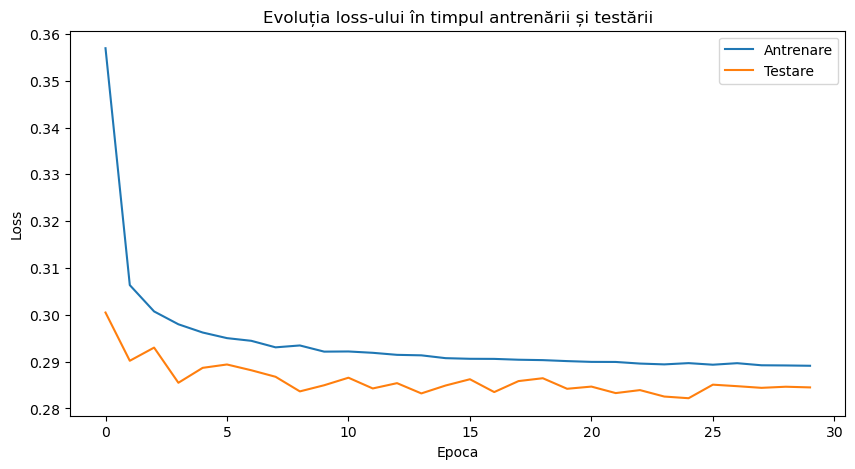

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Antrenare')
plt.plot(losses_test, label='Testare')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Evoluția loss-ului în timpul antrenării și testării')
plt.legend()
plt.show()

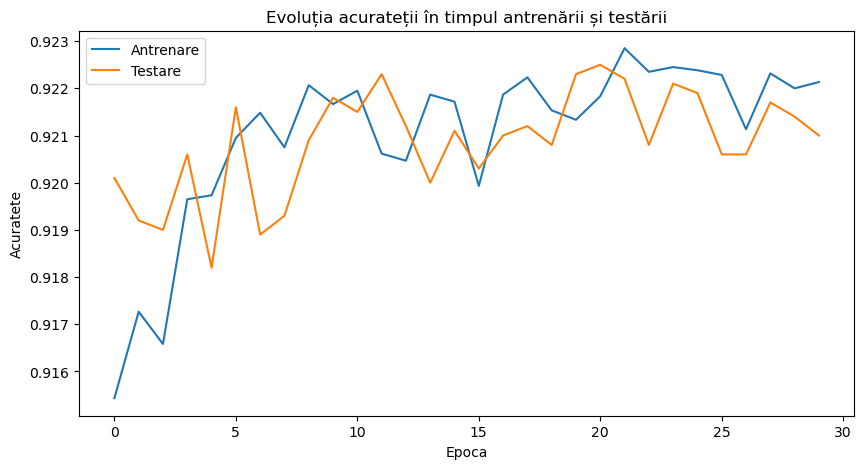

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(accuracies_train, label='Antrenare')
plt.plot(accuracies_test, label='Testare')
plt.xlabel('Epoca')
plt.ylabel('Acuratete')
plt.title('Evoluția acurateții în timpul antrenării și testării')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import confusion_matrix
import tableprint as tab
# Inițializăm listele pentru stocarea predicțiilor și etichetelor adevărate pe setul de testare
y_pred = []
y_true = []

# 
with torch.no_grad():
    model.eval()
    for x_test, y_test in test_loader:
        # Trecem datele de testare pe același dispozitiv ca și modelul
        x_test, y_test = x_test.to(device), y_test.to(device)
        
        logits_test = model(x_test)
        predictions = torch.argmax(logits_test, dim=1)  # Determinăm clasa prezisă pentru fiecare exemplu
        
        
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_test.cpu().numpy())

# Calculăm matricea de confuzie și precizia modelului
cm = confusion_matrix(y_true, y_pred)
headers = ['CnfMat'] + [f'pr: {x}' for x in range(cm.shape[1])] + ['all a'] 
table = []

for i in range(cm.shape[0]):
    table.append([f'act: {i}'] + list(cm[i]) + [sum(cm[i])])
table.append(['all p'] + [sum(cm[:, i]) for i in range(cm.shape[1])] + [sum(sum(cm))])
tab.table(table, headers, width=6)



╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    960 │      0 │      1 │      2 │      0 │      5 │      8 │      1 │      3 │      0 │    980 │
│ act: 1 │      0 │   1110 │      2 │      2 │      0 │      2 │      4 │      2 │     13 │      0 │   1135 │
│ act: 2 │      6 │      8 │    913 │     19 │     11 │      3 │     12 │     11 │     41 │      8 │   1032 │
│ act: 3 │      3 │      0 │     17 │    931 │      0 │     20 │      2 │     10 │     19 │      8 │   1010 │
│ act: 4 │      1 │      3 │      4 │      1 │    911 │      0 │     11 │      2 │     10 │     39 │    982 │
│ act: 5 │      9 │      3 │      3 │     47 │      8 │    761 │     17 │      6 │     31 │      7 │    892 │
│ act: 6 │